# Classification and analyzis of Dutch train stations

##  Introduction

The Netherlands have an extensive rail network with many stations.

The last years more and more businesses and population are concentrating around stations. Also stations are extended with shops, horeca and office facilities to make them more attractive.

Stations are very different: 
* Major hubs in big cities with many perons and many passengers. 
* Local stations in the country side close to a small town in the middle of the fields.

Dutch railnetwerk in 2018:

<img src="./spoorkaart-2018.jpg" alt="drawing" width="500"/>

## Business Problem 

The question is what are good candidate stations to invest in facilities, like shops or horeca facilities.<br/>
The anwser to this question helps an business invester to make the right investement decisions.<br/>
The goal is analyse and cluster the trainstations in the Netherlands based on the characteristic of the stations and thier neighborhood.

## Data

The required data is:
1. the Dutch train stations and their coordinates
2. the facilities at and around these train stations

The data for point 1) is available at the NS API https://www.ns.nl/en/travel-information/ns-api. The NS is the major Dutch train operator. The API provides an Station section with endpoints to:
* get a list and coordinates of the trainstations
* get details per station.

Regarding point 2) this information is available via the FourSquare API. Via this API we retrieve the facilities very close to the station. Secondly also we retrieve the facilities in the stations neighorhoud, e.g. like horeca and museums. The stations details endpoint of the NS API will also provide details for each station.

In the Foursquare we explore the venues for the following sub-categories:
* Arts & Entertainment (4d4b7104d754a06370d81259)
* College & University (4d4b7105d754a06372d81259)
* Event (4d4b7105d754a06373d81259)
* Food (4d4b7105d754a06374d81259)
* Nightlife Spot (4d4b7105d754a06376d81259)
* Outdoors & Recreation (4d4b7105d754a06377d81259)
* Professional & Other Places (4d4b7105d754a06375d81259)
* Residence (4e67e38e036454776db1fb3a)
* Shop & Service (4d4b7105d754a06378d81259)
* Travel & Transport (4d4b7105d754a06379d81259)

We’ll be querying the number of venues in each category in a 1000m radius around each train station. 1000m is a reasonable walking distance.

Example station data:

In [2]:
import http, urllib, base64
import pandas as pd
import numpy as np
import json
import requests
# from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
# import re
import matplotlib.cm as cm
import matplotlib.colors as colors

In [3]:
secrets = json.load(open('secrets.json'))

FOURSQUARE_CLIENT_ID = secrets['foursquare']['client_id']
FOURSQUARE_CLIENT_SECRET = secrets['foursquare']['client_secret']
FOURSQUARE_VERSION = secrets['foursquare']['version']
NS_API_KEY = secrets['ns-api']['key']

In [4]:
headers = {
    # Request headers
    'Accept-Language': '',
    'Ocp-Apim-Subscription-Key': NS_API_KEY,
}
params = urllib.parse.urlencode({
})

try:
    conn = http.client.HTTPSConnection('gateway.apiportal.ns.nl')
    conn.request("GET", "/ns-international-station-api/nearby?lat={lat}&lon={lon}&k={k}&%s" % params, "{body}", headers)
    response = conn.getresponse()
    data = response.read()
    print(data)
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))                    

b'{ "statusCode": 401, "message": "Access denied due to invalid subscription key. Make sure to provide a valid key for an active subscription." }'


In [7]:
all_stations_df = pd.read_csv('ns_stations.csv')
stations_df = all_stations_df[all_stations_df['Land']=='Netherlands'].reset_index()
stations_df.head(10)

,index,Station,Code,Lat,Lon,Straat,Huisnummer,Postcode,Plaats,Land
0,0,s-Hertogenbosch,HT,51.690480,5.293620,Stationspasserelle,10,5211 AZ,'s-Hertogenbosch,Netherlands
1,1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,Zandzuigerstraat,101,5231 XW,'s-Hertogenbosch,Netherlands
2,2,t Harde,HDE,52.409168,5.893611,Eperweg,123,8084 HD,'t Harde,Netherlands
3,7,Aalten,ATN,51.921327,6.578627,Stationsstraat,38,7122 AT,Aalten,Netherlands
4,8,Abcoude,AC,52.278500,4.977000,Spoorlaan,??,1391,Abcoude,Netherlands
5,12,Akkrum,AKM,53.046391,5.843611,Alde Rykswei,??,8491,Akkrum,Netherlands
6,15,Alkmaar,AMR,52.637779,4.739722,Stationsweg,43B,1815 CB,Alkmaar,Netherlands
7,16,Alkmaar Noord,AMRN,52.643890,4.764167,Drechterwaard,102-104,1824 DX,Alkmaar,Netherlands
8,17,Almelo,AML,52.358055,6.653889,Parallelweg,50,7604 TX,Almelo,Netherlands
9,18,Almelo de Riet,AMRI,52.341946,6.666667,Rietstraat,226,7606 BW,Almelo,Netherlands


Retrieve the FourSquare venues categories

In [8]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            FOURSQUARE_VERSION)
            
# make the GET request
categories = requests.get(categories_url).json()
categories

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5d45aecabf7dde002c53a869'},
 'response': {}}

In [36]:
# def parse_categories(categories, level=0, max_level=0): 
#     categories_list = []
#     if level>max_level: return
#     out = ''
#     out += '-'*level
#     for category in categories:
#         parse_categories(category['categories'], level+1, max_level)
#         categories_list.append((category['name'], category['id']))
#     return categories_list

# categories_list_df = pd.DataFrame(parse_categories(categories['response']['categories'], 0, 0), columns=["Category", "Id"])
# categories_list_df = categories_list_df[~categories_list_df['Category'].isin(['Event', 'Residence'])].reset_index()
# categories_list_df.to_csv('categories_list.csv')
# categories_list_df

KeyError: 'categories'

In [9]:
categories_list_df = pd.read_csv('categories_list.csv')[['Category', 'Id']]
categories_list_df

,Category,Id
0,Arts & Entertainment,4d4b7104d754a06370d81259
1,College & University,4d4b7105d754a06372d81259
2,Food,4d4b7105d754a06374d81259
3,Nightlife Spot,4d4b7105d754a06376d81259
4,Outdoors & Recreation,4d4b7105d754a06377d81259
5,Professional & Other Places,4d4b7105d754a06375d81259
6,Shop & Service,4d4b7105d754a06378d81259
7,Travel & Transport,4d4b7105d754a06379d81259


Count the number of venues per category per station

In [10]:
# Create a dedicated dataframe to store venues data
stations_venues_df = stations_df[['Station', 'Code', 'Lat', 'Lon']].copy()
# # stations_venues_df = stations_df.copy()
for c in categories_list_df['Category']:
    stations_venues_df[c] = 0
    
stations_venues_df

,Station,Code,Lat,Lon,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,s-Hertogenbosch,HT,51.690480,5.293620,0,0,0,0,0,0,0,0
1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,0,0,0,0,0,0,0,0
2,t Harde,HDE,52.409168,5.893611,0,0,0,0,0,0,0,0
3,Aalten,ATN,51.921327,6.578627,0,0,0,0,0,0,0,0
4,Abcoude,AC,52.278500,4.977000,0,0,0,0,0,0,0,0
5,Akkrum,AKM,53.046391,5.843611,0,0,0,0,0,0,0,0
6,Alkmaar,AMR,52.637779,4.739722,0,0,0,0,0,0,0,0
7,Alkmaar Noord,AMRN,52.643890,4.764167,0,0,0,0,0,0,0,0
8,Almelo,AML,52.358055,6.653889,0,0,0,0,0,0,0,0
9,Almelo de Riet,AMRI,52.341946,6.666667,0,0,0,0,0,0,0,0


In [11]:
def get_venues_count(lat, lon, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
                FOURSQUARE_CLIENT_ID, 
                FOURSQUARE_CLIENT_SECRET, 
                FOURSQUARE_VERSION,
                lat,
                lon,
                radius,
                categoryId)

    # make the GET request
    resp = requests.get(explore_url)
    print("response: {}", resp.json())
    return resp.json()['response']['totalResults']


In [12]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df.iterrows():
    if i>=0:
        print(i)
        for c in categories_list_df['Category']:
            try:
                stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df['Lat'].iloc[i], stations_venues_df['Lon'].iloc[i], radius=1000, categoryId=c[1])
            except:
                stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df['Lat'].iloc[i], stations_venues_df['Lon'].iloc[i], radius=1000, categoryId=c[1])
#    stations_venues_df.to_csv('stations_venues.csv')

stations_venues_df

0
response: {} {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d45aee02b274a002c692f26'}, 'response': {}}
response: {} {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d45aee04eefd000261bb718'}, 'response': {}}


KeyError: 'totalResults'

In [ ]:
# stations_venues_df.to_csv('stations_venues_df.csv')

In [13]:
stations_venues_df = pd.read_csv('stations_venues_df.csv')
stations_venues_df

,Unnamed: 0,Station,Code,Lat,Lon,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0,s-Hertogenbosch,HT,51.690480,5.293620,0,0,0,0,0,0,0,0,0,0
1,1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,0,0,0,0,0,0,0,0,0,0
2,2,t Harde,HDE,52.409168,5.893611,0,0,0,0,0,0,0,0,0,0
3,3,Aalten,ATN,51.921327,6.578627,0,0,0,0,0,0,0,0,0,0
4,4,Abcoude,AC,52.278500,4.977000,0,0,0,0,0,0,0,0,0,0
5,5,Akkrum,AKM,53.046391,5.843611,0,0,0,0,0,0,0,0,0,0
6,6,Alkmaar,AMR,52.637779,4.739722,0,0,0,0,0,0,0,0,0,0
7,7,Alkmaar Noord,AMRN,52.643890,4.764167,0,0,0,0,0,0,0,0,0,0
8,8,Almelo,AML,52.358055,6.653889,0,0,0,0,0,0,0,0,0,0
9,9,Almelo de Riet,AMRI,52.341946,6.666667,0,0,0,0,0,0,0,0,0,0


## Data preparation¶

In [14]:
from sklearn.preprocessing import MinMaxScaler

columns = stations_venues_df.columns[5:]
X = stations_venues_df.values[:,5:]
vanue_counts_norm = MinMaxScaler().fit_transform(X)
vanue_counts_norm
columns

C:\Users\Arjan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Index(['Arts & Entertainment', 'College & University', 'Event', 'Food',
       'Nightlife Spot', 'Outdoors & Recreation',
       'Professional & Other Places', 'Residence', 'Shop & Service',
       'Travel & Transport'],
      dtype='object')

In [15]:
vanue_counts_norm_df = pd.DataFrame(vanue_counts_norm, columns=columns)
#cluster_df.columns = [c in categories_list_df['Category']]
vanue_counts_norm_df.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
vanue_counts_norm_df.shape

(413, 10)

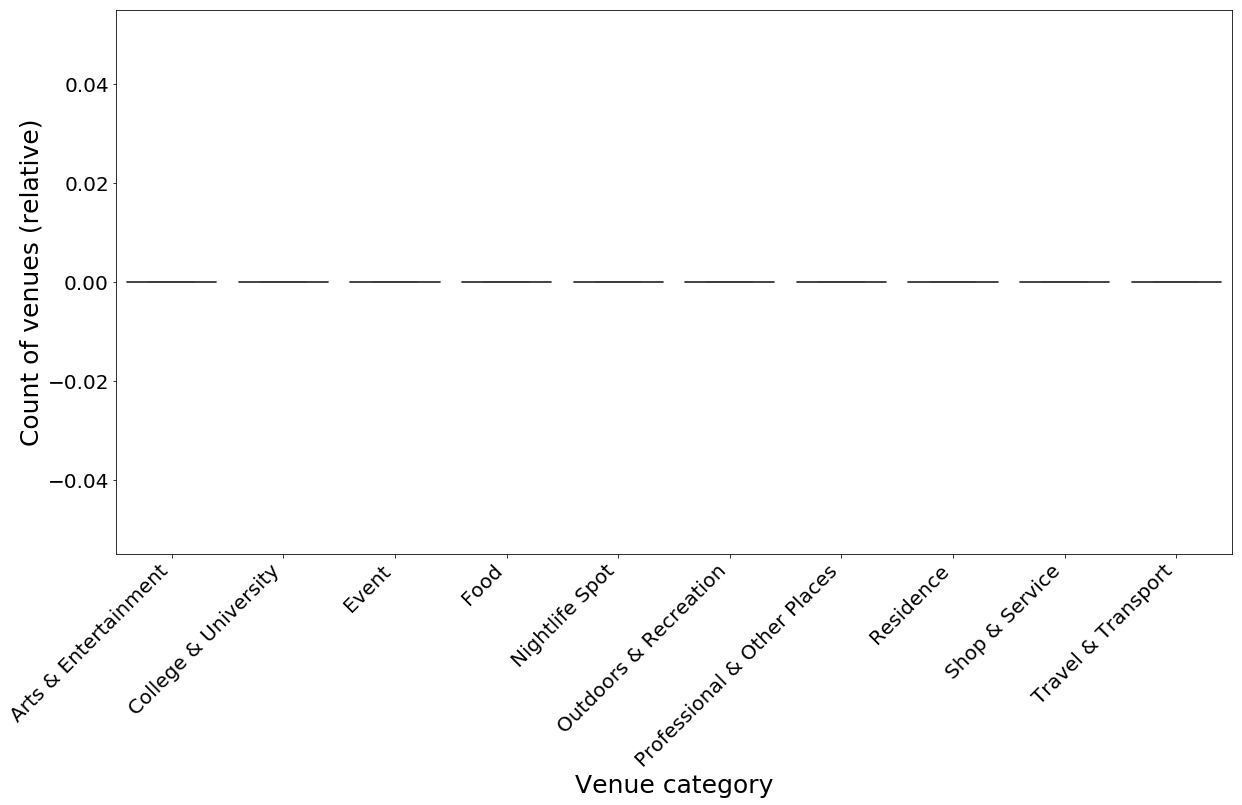

In [17]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = vanue_counts_norm_df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

In [18]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vanue_counts_norm_df)

kmeans_labels = kmeans.labels_
# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

C:\Users\Arjan\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


In [20]:
stations_clusters_df = stations_venues_df.copy()
stations_clusters_df['Cluster'] = kmeans_labels

stations_clusters_minmax_df = stations_clusters_df.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['Station'] = stations_df['Station']
stations_clusters_minmax_df['Lat'] = stations_df['Lat']
stations_clusters_minmax_df['Lon'] = stations_df['Lon']
stations_clusters_minmax_df

,Unnamed: 0,Station,Code,Lat,Lon,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Cluster
0,0,s-Hertogenbosch,HT,51.690480,5.293620,0,0,0,0,0,0,0,0,0,0,2
1,1,s-Hertogenbosch Oost,HTO,51.700554,5.318333,0,0,0,0,0,0,0,0,0,0,2
2,2,t Harde,HDE,52.409168,5.893611,0,0,0,0,0,0,0,0,0,0,2
3,3,Aalten,ATN,51.921327,6.578627,0,0,0,0,0,0,0,0,0,0,2
4,4,Abcoude,AC,52.278500,4.977000,0,0,0,0,0,0,0,0,0,0,2
5,5,Akkrum,AKM,53.046391,5.843611,0,0,0,0,0,0,0,0,0,0,2
6,6,Alkmaar,AMR,52.637779,4.739722,0,0,0,0,0,0,0,0,0,0,2
7,7,Alkmaar Noord,AMRN,52.643890,4.764167,0,0,0,0,0,0,0,0,0,0,2
8,8,Almelo,AML,52.358055,6.653889,0,0,0,0,0,0,0,0,0,0,2
9,9,Almelo de Riet,AMRI,52.341946,6.666667,0,0,0,0,0,0,0,0,0,0,2


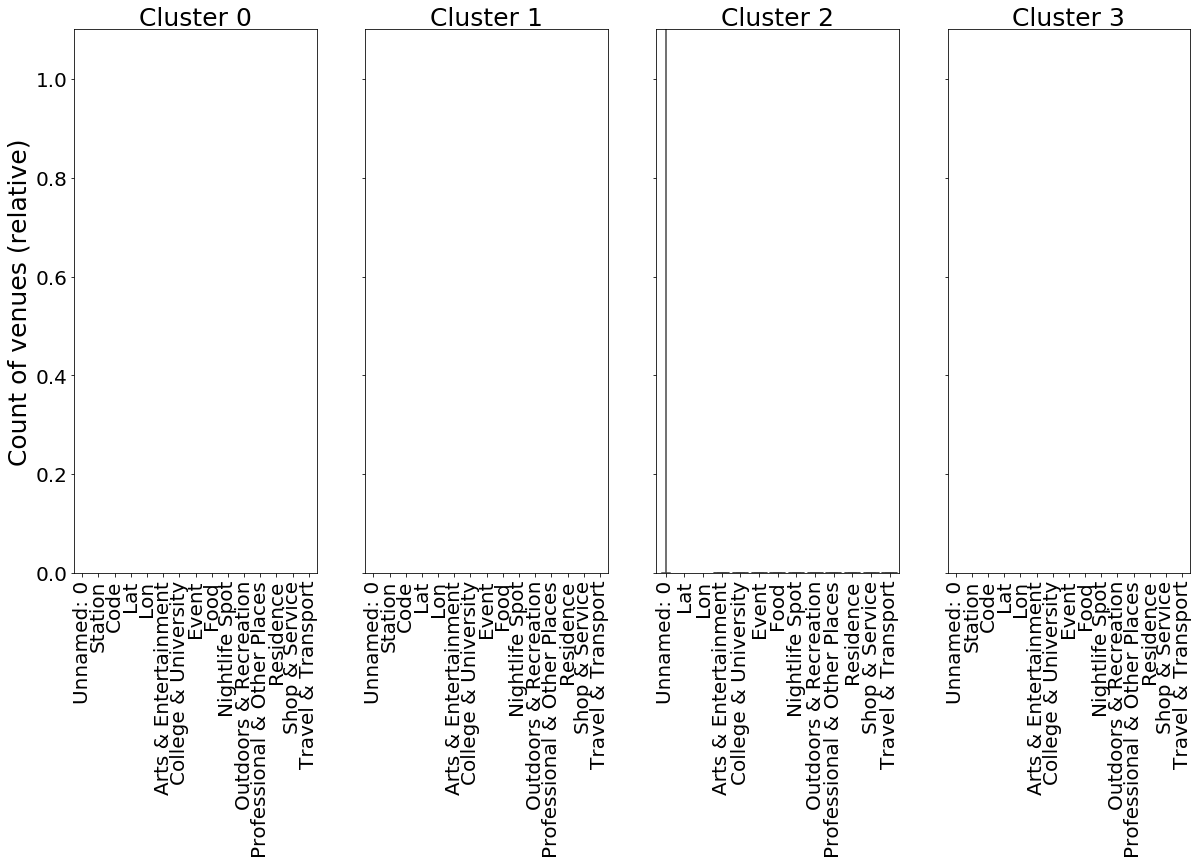

In [21]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,kclusters, figsize=(20, 10), sharey=True)

axes[0].set_ylabel('Count of venues (relative)', fontsize=25)
#plt.set_xlabel('Venue category', fontsize='x-large')

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

In [22]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
location = 'Netherlands'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(location)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(location, latitude, longitude))

The geograpical coordinate of Nederland are 52.24726925, 5.54122345487672.


In [23]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stations_clusters_df['Lat'], stations_clusters_df['Lon'], stations_clusters_df['Station'], stations_clusters_df['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [69]:
# def draw_lines(dataframe, map_object, opacity=1):
#     prev_coordinates = None
#     prev_line = '1'
#     for line, coordinates in zip(dataframe['Line'], dataframe['Coordinates']):
#         latlong = [float(x) for x in coordinates.split(',')]
#         #don't draw line if line number changed
#         if line != prev_line:
#             prev_coordinates = None
#         if prev_coordinates != None:
#             folium.PolyLine([prev_coordinates, latlong], color=line_colors[line], opacity=opacity).add_to(map_object)
#         prev_line = line
#         prev_coordinates = latlong    
    
#     #special case for two circle lines
#     for line in ['5','14']:
#         first_station = dataframe[dataframe['Line'] == line].iloc[0]['Coordinates']
#         last_station = dataframe.iloc[dataframe[stations_df['Line'] == line].last_valid_index()]['Coordinates']    
#         print()
#         print()
#         folium.PolyLine([[float(x) for x in first_station.split(',')],
#                          [float(x) for x in last_station.split(',')]],
#                         color=line_colors[line], opacity=opacity).add_to(map_object)

In [71]:
# #create map with all stations
# map_stations = folium.Map(location=[latitude, longitude], zoom_start=8)

# draw_lines(stations_df, map_stations, 0.9)

# #add markers
# for i, station, coordinates, cluster in zip(stations_clusters_minmax_df.index,
#                                          stations_clusters_minmax_df['English name'],
#                                          stations_clusters_minmax_df['Coordinates'],
#                                          stations_clusters_minmax_df['Cluster']):
#     latlong = [float(x) for x in coordinates.split(',')]    
#     #colors = sns.color_palette(None, kclusters).as_hex()
#     colors=['blue','green','orange','red']
#     #Calculate top 3 categories for each station
#     station_series = stations_clusters_minmax_df.iloc[i]
#     top_categories_dict = {}
#     for cat in categories_list:
#         top_categories_dict[cat[0]] = station_series[cat[0]]
#     top_categories = sorted(top_categories_dict.items(), key = lambda x: x[1], reverse=True)
#     popup='<b>{}</b><br>Cluster {}<br>1. {} {}<br>2. {} {}<br>3. {} {}'.format(
#         station,
#         cluster,
#         top_categories[0][0],
#         "{0:.2f}".format(top_categories[0][1]),
#         top_categories[1][0],
#         "{0:.2f}".format(top_categories[1][1]),
#         top_categories[2][0],
#         "{0:.2f}".format(top_categories[2][1]))
#     folium.CircleMarker(
#         latlong,
#         fill=True,
#         fill_opacity=0.5,
#         popup=folium.Popup(popup, max_width = 300),
#         radius=5,
#         color=colors[cluster]
#     ).add_to(map_stations)
    
# map_stations

KeyError: 'Line'